# Black Scholes

We want to price an arbitrary European Contingent Claim in the setting of a Black Scholes Model. 
Since this can not be done analytically in most cases (unless you have a vanilla call/put option or other very simple options), we use a Monte Carlo simulation for those cases.
We also apply variance reduction methods for Monte Carlo, to make our computation more efficient. As centered variance reduction variables, we will use the simulation of options for which we know the analytic price.


For the simulation of the stock price process, we are going to use a LogEuler scheme.

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


## Some analytical prices

In [10]:
def analyticEuropeanCall(r: float, t:float, T:float, K:float, S:float, sigma: float):
    """returns analytic price for european call option under Black Scholes

    Args:
        r (float): risk free rate
        t (float): initial time
        T (float): maturity
        K (float): Strike
        S (float): Stock Price
        sigma (float): volatility

    Returns:
        (float): Analytic price under Black Scholes for a european call option
    """
    d1 = (np.log(S/K) + (r + sigma**2 /2)* (T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma* np.sqrt(T-t)
    return (S* stats.norm.cdf(d1) - K *np.exp(-r*(T-t))*stats.norm.cdf(d2)).item()

In [11]:
def analyticEuropeanPut(r: float, t:float, T:float, K:float, S:float, sigma: float):
    """returns analytic price for european put option under Black Scholes

    Args:
        r (float): risk free rate
        t (float): initial time
        T (float): maturity
        K (float): Strike
        S (float): Stock Price
        sigma (float): volatility

    Returns:
        (float): Analytic price under Black Scholes for a european put option
    """
    d1 = (np.log(S/K) + (r + sigma**2 /2)* (T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma* np.sqrt(T-t)
    return (-S* stats.norm.cdf(-d1) + K *np.exp(-r*(T-t))*stats.norm.cdf(-d2)).item()

## Monte Carlo Simulation Stock Price

In [12]:
def stockPrice_Sim_BS_Milstein_Scheme(S0:float, mu:float, sigma:float, T:float, N:int, M:int):
    """Generates M sample paths for a stock price simulation under the geometric brownian motion, i.e. Black Scholes model.
    For the discretization, we use the Milstein Scheme.

    Args:
        S0 (float): initial stock price
        mu (float): drift
        sigma (float): volatility
        T (float): maturity
        N (int): Number of time steps
        M (int): Number of sample paths

    Returns:
        (np.array): Sample Paths from stock price simulation
    """

    dt = T / N
    S = np.zeros((M, N+1))
    S[:, 0] = S0

    # Simulate paths using Milstein
    for i in range(N):
        dW = np.random.normal(0, np.sqrt(dt), size=M)
        S[:, i+1] = (S[:, i] + mu * S[:, i] * dt + sigma * S[:, i] * dW
                     + 0.5 * sigma**2 * S[:, i] * (dW**2 - dt) )
        
    return S

In [13]:
def europeanCallOption_Sim(S:np.array, K:float, r:float,t:float, T:float):
    """Given the simulation of a stockprice, this function computes the Call Option value at maturity for every single sample path.

    Args:
        S (np.array): Stock price simulation as a (samplesize, NumDiscretizationSteps) array.
        K (float): Strike
        r (float): risk free rate
        t (float): initial time
        T (float): maturity

    Returns:
        (np.array): (samplesize,) shape array, which contains the single option values for the sample paths
    """
    S = S[:, -1].reshape(-1)
    return np.exp(-r * (T-t)) * np.maximum(0, S-K)

In [14]:
def europeanPutOption_Sim(S:np.array, K:float, r:float,t:float, T:float):
    """Given the simulation of a stockprice, this function computes the Put Option value at maturity for every single sample path.

    Args:
        S (np.array): Stock price simulation as a (samplesize, NumDiscretizationSteps) array.
        K (float): Strike
        r (float): risk free rate
        t (float): initial time
        T (float): maturity

    Returns:
        (np.array): (samplesize,) shape array, which contains the single option values for the sample paths
    """
    S = S[:, -1].reshape(-1)
    return np.exp(-r * (T-t)) * np.maximum(0, K-S)

### Quick Sanity Check:

In [15]:
S0 = 100   
mu = 0.05    
r = mu
sigma = 0.2  
t = 0
T = 1   
K = 110
N = 300
M = 5000

anaCall = analyticEuropeanCall(r, t, T, K, S0, sigma)
anaPut = analyticEuropeanPut(r, t, T, K, S0, sigma)

S = stockPrice_Sim_BS_Milstein_Scheme(S0, mu, sigma, T, N, M)

simCall = europeanCallOption_Sim(S, K, r, t ,T)
simPut  = europeanPutOption_Sim(S, K, r, t ,T)

simCall_mean = np.mean(simCall)
simPut_mean  = np.mean(simPut)

simCall_std = np.std(simCall)
simPut_std  = np.std(simPut)

# for confidence intervall c from standard normal distribution for confidence level 0.95, i.e. 2.5 percentile
c = 1.96
print(f"Analytic   Call...............{anaCall}")
print(f"Simulation Call...............{simCall_mean} +- { c* simCall_std/ np.sqrt(M).item()}")
print("______________________________________________")
print(f"Analytic   Put...............{anaPut}")
print(f"Simulation Put...............{simPut_mean} +- { c* simPut_std/ np.sqrt(M).item()}")

Analytic   Call...............6.040088129724239
Simulation Call...............6.259603708361672 +- 0.3308727366804532
______________________________________________
Analytic   Put...............10.675324824802793
Simulation Put...............10.643652368603286 +- 0.3350167784612511


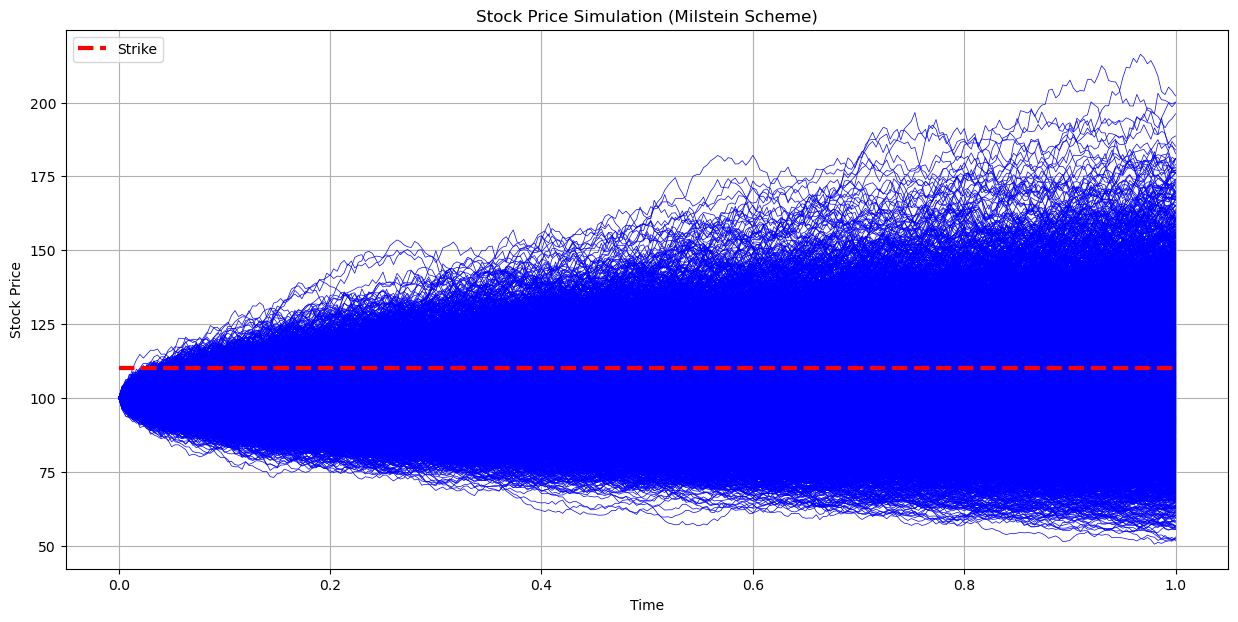

In [16]:
# Plot Stock Price
tgrid = np.linspace(t, T, N+1)
plt.figure(figsize=(15, 7))
for j in range(M):
    plt.plot(tgrid, S[j], linewidth=0.5, c = "b")

plt.hlines(y=[K], xmax=T, xmin=t, colors=["r"], linestyles=['--'], label="Strike", linewidth=3)
plt.title('Stock Price Simulation (Milstein Scheme)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

We see that most paths from the simulation are under the strike at maturity. Thus it makes sense, that the put option is more valuable, which is both confirmed by the analytic formula and by the simulation.

**BUT** the standard deviation of our sample paths and thus also the confidence interval we can give is still very high!

## Variance Reduction

We want to use variance reduction, to reduce the standard error of our simulation. The main idea of variance reduction is that if you have some simulation of an (exotic) option, then you can also evaluate the simulation of an option for which you know how it should be centered analytically and then compensate for a certain tendency in one direction. The idea will be clearer with some math:

Lets say we have a simulation of an exotic option $(\tilde X_1 ,..., \tilde X_M)$ and M sample paths and we want to compute the mean to get the price, i.e. we want 
$\bar X \approx \mathbb E [X]$ 
where $\tilde X_1$ sampled from $X$.
Let's say we also have **UNDER THE SAME SIMULATION** samples $(\tilde Y_1 ,..., \tilde Y_M)$ from a centered random variable $ \mathbb E [Y] = 0$. For Y we can use e.g. a vanilla call/put option minus its analytic price. Then for
$Z = X - c\cdot (Y)$
we have, that  $\mathbb E [X] = \mathbb E[Y]$ for all $c \in \mathbb R$.

The key observation is that if we choose a good $c \in \mathbb R$, then we can reduce the variance of $Z$ while maintaining the same mean.

$c \mapsto Var (Z_c) =  Var (X) - 2 c \cdot Cov (X,Y) + c^2 Var (Y)$ and the minimum is attained at $c^* = {Cov(X,Y) \over Var(Y)}$.

Note, that this can also be interprated as a simple linear regression, where we want to model $Z - X$ with the observable $Y$, since ${Cov(Z_{c^*}-X,Y) \over Var(Y)} = -{Cov(X,Y) \over Var(Y)}$, since
$$Cov(Z_{c^*},Y) = Cov(X, Y) - c^* \cdot Var(Y) = Cov(X, Y) - {Cov(X,Y) \over Var(Y)} \cdot Var(Y) = 0$$

Thus $c^*$ is the optimal slope for this linear model.

In [164]:
def varianceReduction_VanillaCall(S:np.array, X:np.array, r:float, t:float, T:float, K:float, sigma:float):
    """Performs variance reduction with a vanilla Call option for input simulation values X (this is our exotic), which is derived from a simulation S (stock price).

    Args:
        S (np.array): Stock Price Simulation
        X (np.array): Values of exotic at maturity for sample paths derived from S
        r (float): risk free rate
        t (float): initial time
        T (float): maturity
        K (float): strike
        sigma (float): volatility

    Returns:
        (np.array): Z from variance reduction
    """
    S0 = S[0,0]

    analyticCall = analyticEuropeanCall(r, t, T, K, S0, sigma)
    simulationCall = europeanCallOption_Sim(S, K, r, t ,T)
    Y = simulationCall - analyticCall

    cov_X_Y = np.cov(X, Y)[0, 1]
    var_Y = np.var(Y)

    return X - (cov_X_Y / var_Y)* Y


In [165]:
def varianceReduction_VanillaPut(S:np.array, X:np.array, r:float, t:float, T:float, K:float, sigma:float):
    """Performs variance reduction with a vanilla Put option for input simulation values X (this is our exotic), which is derived from a simulation S (stock price).

    Args:
        S (np.array): Stock Price Simulation
        X (np.array): Values of exotic at maturity for sample paths derived from S
        r (float): risk free rate
        t (float): initial time
        T (float): maturity
        K (float): strike
        sigma (float): volatility

    Returns:
        (np.array): Z from variance reduction
    """
    S0 = S[0,0]

    analyticPut = analyticEuropeanPut(r, t, T, K, S0, sigma)
    simulationPut = europeanPutOption_Sim(S, K, r, t ,T)
    Y = simulationPut - analyticPut

    cov_X_Y = np.cov(X, Y)[0, 1]
    var_Y = np.var(Y)

    return X - (cov_X_Y / var_Y)* Y

### Quick Sanity Check:

In [170]:
S0 = 100   
mu = 0.05    
r = mu
sigma = 0.2  
t = 0
T = 1   
K = 110
N = 300
M = 200

anaCall = analyticEuropeanCall(r, t, T, K, S0, sigma)
anaPut = analyticEuropeanPut(r, t, T, K, S0, sigma)

S = stockPrice_Sim_BS_Milstein_Scheme(S0, mu, sigma, T, N, M)

simCall = europeanCallOption_Sim(S, K, r, t ,T)
simPut  = europeanPutOption_Sim(S, K, r, t ,T)

simCall_mean = np.mean(simCall)
simPut_mean  = np.mean(simPut)

simCall_std = np.std(simCall)
simPut_std  = np.std(simPut)

# We reduce the variance with a call option for the put option and with a put option for the call option

reduced_var_Call = varianceReduction_VanillaPut(S, simCall, r, t, T, K, sigma)
reduced_var_Put = varianceReduction_VanillaCall(S, simPut, r, t, T, K, sigma)

reduced_var_simCall_mean = np.mean(reduced_var_Call)
reduced_var_simPut_mean  = np.mean(reduced_var_Put)

reduced_var_simCall_std = np.std(reduced_var_Call)
reduced_var_simPut_std  = np.std(reduced_var_Put)




# for confidence intervall c from standard normal distribution for confidence level 0.95, i.e. 2.5 percentile
c = 1.96
print(f"Analytic   Call...........................{anaCall}")
print(f"Simulation Call...........................{simCall_mean} +- { c* simCall_std/ np.sqrt(M).item()}")
print(f"Reduced Variance Simulation Call..........{reduced_var_simCall_mean} +- { c* reduced_var_simCall_std/ np.sqrt(M).item()}")
print("______________________________________________")
print(f"Analytic   Put...........................{anaPut}")
print(f"Simulation Put...........................{simPut_mean} +- { c* simPut_std/ np.sqrt(M).item()}")
print(f"Reduced Variance Simulation Put..........{reduced_var_simPut_mean} +- { c* reduced_var_simPut_std/ np.sqrt(M).item()}")

Analytic   Call...........................6.040088129724239
Simulation Call...........................7.6506139245399325 +- 2.0952630768800002
Reduced Variance Simulation Call..........7.19525196721401 +- 1.9095975139096228
______________________________________________
Analytic   Put...........................10.675324824802793
Simulation Put...........................9.797989713862009 +- 1.6697465258532633
Reduced Variance Simulation Put..........10.328853252207717 +- 1.521786858085905


We see that all worked perfectly :)